In [1]:
import os
import sys
import math
import time
import copy
import random
import tempfile
from functools import reduce
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax
import scipy.io

import torch
from torch import nn
import torch.nn.functional as F

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer, PlanarLayer

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
log2PI = np.log(2*math.pi)
dev = torch.device('cpu')

In [4]:
epochs = 1000

## Aux methods

In [5]:
def save_model(name, model_dict, path='.'):
    full_path = os.path.join(path, name)
    
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    model = model_dict['model']
    x_mean = model_dict['x_mean']
    x_std = model_dict['x_std']
    
    # Save pytorch model
    torch.save(model.state_dict(), os.path.join(full_path, 'model.pth'))
    
    # Save normalization constants
    np.save(os.path.join(full_path, 'x_mean.npy'), x_mean)
    np.save(os.path.join(full_path, 'x_std.npy'), x_std)

In [6]:
def train_flow(train, test):
    dim = train.shape[1]
    x_mean, x_std = np.mean(train, axis=0, keepdims=True), np.std(train, axis=0, keepdims=True)
    
    train, test = (train - x_mean)/x_std, (test - x_mean)/x_std
    
    # Convertir a pytorch
    X = torch.as_tensor(train, dtype=torch.float).to(dev)
    Test = torch.as_tensor(test, dtype=torch.float).to(dev)

    # Instantiate model
    model = Flow([NvpCouplingLayer(dim, hidden_size=[10, 10]) for _ in range(10)]).to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

    loss = []
    logpz = []
    logdet = []

    # Train loop
    t0 = time.time()
    model.train()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        preds, _logdet = model(X)

        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(-0.5 * (log2PI*dim + torch.sum(torch.pow(preds[-1], 2), dim=1)))
        _loss = -_logpz - _logdet*(e>10)

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())
        
        if e%10 == 9:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")
         
    model.eval()
    g_train, _ = model(X)
    g_train = g_train[-1].detach().cpu().numpy()
    
    g_test, _ = model(Test)
    g_test = g_test[-1].detach().cpu().numpy()
    
    model_dict = {
        'model': model,
        'logpz': np.array(logpz),
        'logdet': np.array(logdet),
        'x_mean': x_mean,
        'x_std': x_std,
    }
        
    return model_dict, g_train, g_test

## Load data

In [7]:
data_path = os.path.join('..', 'enusa')

mat_train = scipy.io.loadmat(os.path.join(data_path, 'datosentrenamiento_NF.mat'))
mat_train = mat_train['datosentrenamiento_NF']
mat_train_g = copy.deepcopy(mat_train)
mat_test = scipy.io.loadmat(os.path.join(data_path, 'datostest_NF.mat'))
mat_test = mat_test['datostest_NF']
mat_test_g = copy.deepcopy(mat_test)

Central: 0
Ciclo: 0


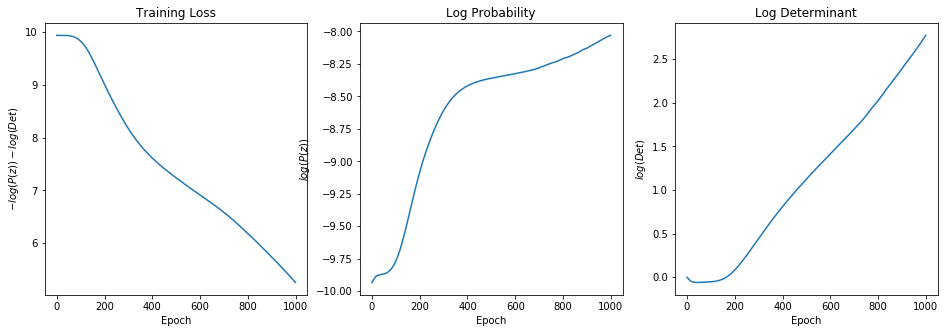

Ciclo: 1


KeyboardInterrupt: 

In [8]:
for central in range(mat_train.shape[0]):
    print('Central: {:d}'.format(central))
    for ciclo in range(mat_train.shape[1]):
        print('Ciclo: {:d}'.format(ciclo))
        if mat_train[central, ciclo].size <= 0:
            print('La central {:d} no tiene tantos ciclos majo'.format(central))
            break
            
        mat_train_g[central, ciclo][0, 0] = np.nan
        while(np.isnan(np.sum(mat_train_g[central, ciclo]))or np.isnan(np.sum(mat_test_g[central, ciclo]))):
            train = mat_train[central, ciclo]
            test = mat_test[central, ciclo]

            model_dict, g_train, g_test = train_flow(train, test)

            mat_train_g[central, ciclo] = g_train
            mat_test_g[central, ciclo] = g_test

            # Save model
            name = os.path.join(data_path, 'central{:d}ciclo{:d}'.format(central, ciclo))

            save_model(name, model_dict, path=name)
            # Plot training NLL
            fig, ax = plt.subplots(1, 3, figsize=(16, 5))

            ax[0].plot(-(model_dict['logpz'] + model_dict['logdet']))
            ax[1].plot(model_dict['logpz'])
            ax[2].plot(model_dict['logdet'])


            ax[0].set_title('Training Loss')
            ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
            ax[0].set_xlabel('Epoch')

            ax[1].set_title('Log Probability')
            ax[1].set_ylabel(r'$log(P(z))$')
            ax[1].set_xlabel('Epoch')

            ax[2].set_title('Log Determinant')
            ax[2].set_ylabel(r'$log(Det)$')
            ax[2].set_xlabel('Epoch')

            plt.show()
        
        
        

In [ ]:
for central in range(mat_train.shape[0]):
    print('Central: {:d}'.format(central))
    for ciclo in range(mat_train.shape[1]):
        print('Ciclo: {:d}'.format(ciclo))
        if mat_train[central, ciclo].size <= 0:
            print('La central {:d} no tiene tantos ciclos majo'.format(central))
            break
        if np.isnan(np.sum(mat_train_g[central, ciclo])):
            print('Nans in train')
        if np.isnan(np.sum(mat_test_g[central, ciclo])):
            print('Nans in test')
        

In [ ]:
train.std()